In [8]:
# Scientific computing
import scipy.signal as sig
import numpy as np

# Data Frame Utility
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio IO and processing
import os
import librosa
import soundfile as sf

In [9]:
tr_df = pd.read_csv('data/train.csv')
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            21375 non-null  float64
 1   playback_used     19575 non-null  object 
 2   ebird_code        21375 non-null  object 
 3   channels          21375 non-null  object 
 4   date              21375 non-null  object 
 5   pitch             21375 non-null  object 
 6   duration          21375 non-null  int64  
 7   filename          21375 non-null  object 
 8   speed             21375 non-null  object 
 9   species           21375 non-null  object 
 10  number_of_notes   21375 non-null  object 
 11  title             21375 non-null  object 
 12  secondary_labels  21375 non-null  object 
 13  bird_seen         19575 non-null  object 
 14  sci_name          21375 non-null  object 
 15  location          21375 non-null  object 
 16  latitude          21375 non-null  object

In [10]:
# Convert any columns of type 'object' to string type.
for column in tr_df.columns:
    if tr_df[column].dtype == 'object':
        tr_df[column] = tr_df[column].astype("string")


### Recorded Signal Data
Let's look at file types, recording length, and sampling rates to get an idea how we can process all this data to be uniform and easier to work with:

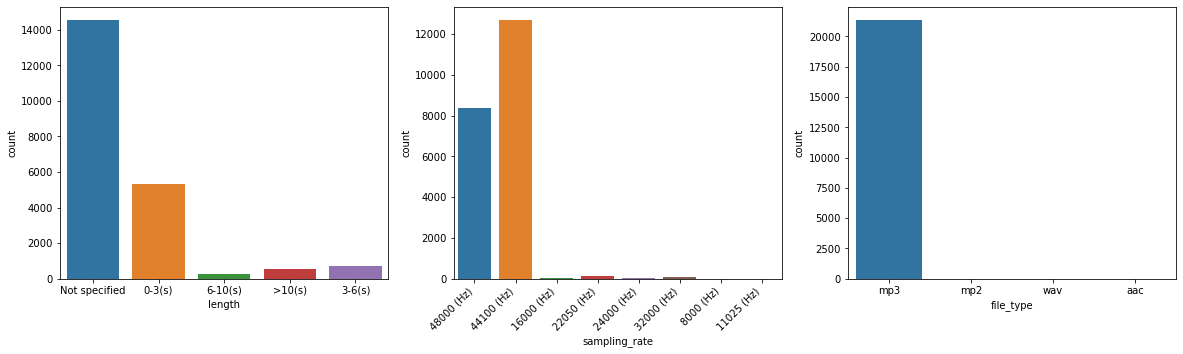

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
ax0 = sns.countplot(x='length', data=tr_df, ax=axes[0])
ax1 = sns.countplot(x='sampling_rate', data=tr_df, ax=axes[1])
ax2 = sns.countplot(x='file_type', data=tr_df, ax=axes[2])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [7]:
# It's hard to tell by the graphs whether or not any file types besides mp3 exist:
tr_df.file_type.value_counts()

mp3    21367
wav        6
aac        1
mp2        1
Name: file_type, dtype: int64

Okay, the files are of many different lengths and sampling rates. There are also several different file types, with .mp3 dominating the landscape. 

# Pre-Processing:
We want all of our data to be of the same size and format for ease of use. 

## Sample Rate

We'll deal with resampling the data by simply loading the data with Librosa's default sampling rate of 22050, and then resaving to disk. This will effectively up or downsample all of the files. We will also convert each file to `.wav` format, as `mp3` support with most audio libraries that I can find is minimal. 

There is a second benefit to using 22050 Hz, and that is that this sampling rate is sufficient to minimally resolve natrual frequencies of up to 11 kHz. Most species of birds have calls that fall below this range, so we shouldn't lose much valuable information. 

First, let's see how to load, resample and convert one file to `.wav`. Then we'll reload this new file and make sure that the audio plays back as expected:

In [13]:
# Test one file conversion:

fpath = '/home/jupyter/jn-kaggle/birdsong/data/train_audio/aldfly/XC134874.mp3'
audio, sr = librosa.load(fpath)

new_fpath = os.path.splitext(fpath)[0] + '.wav'

with sf.SoundFile(new_fpath, 'w', sr, channels=1, format='WAV') as f:
    f.write(audio)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [14]:
# Make sure that new .wav file was saved correctly
import IPython
IPython.display.Audio(new_fpath)

Sampling Rate: 22050


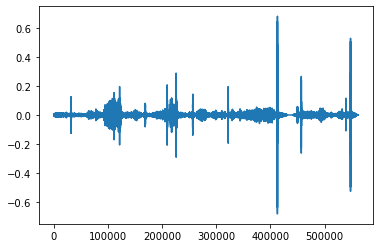

In [15]:
a, sr = librosa.load(new_fpath)
print(f'Sampling Rate: {sr}')
plt.plot(a)

Next, we want to automate this process. Below are a few helper functions that will be applied using a multiprocessing `Pool` object.

In [17]:
import warnings
from multiprocessing import Pool
from IPython.display import clear_output

# Load an audio file in librosa from file path
def read_audio(file_path):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        aud, _ = librosa.load(fpath) 
    return aud

# write audio to file. Input is tuple (write_path, audio)
def write_audio(info):
    os.makedirs(os.path.dirname(info[0]), exist_ok=True)
    with sf.SoundFile(info[0], 'w', sr, channels=1, format='WAV') as f:
        f.write(info[1])

# rename extension
def rename(file_path):
    return os.path.splitext(file_path)[0] + '.wav'

Next, we will re-write all of the sound files at the appropriate sampling rate and save them to a new folder. This will take a minute, so if you're doing this at home, let it run and go take a nap. Or whatever. 

In [18]:
rootdir = '/home/jupyter/jn-kaggle/birdsong/'
train_path = os.path.join(rootdir, 'data/train_audio')
new_path = os.path.join(rootdir, 'data/train')

birds = [d for d in os.scandir(train_path) if os.path.isdir(d.path)]
n_species = len(birds)

for i, bird in enumerate(birds):
    clear_output(wait=True)
    species = bird.name
    
    print(f'Working on species folder {bird.name}')
    print(f'Progress: {int(100 * i/n_species)%}')
    
    files   = [f.name for f in os.scandir(bird)]
    renamed = map(rename, files)
    r_paths = [f.path for f in os.scandir(bird)]
    w_paths = [os.path.join(new_path, species, f) for f in renamed]
    
    
    with Pool(os.cpu_count()) as p:
        print('Loading and Resampling Files...')
        audio = p.map(read_audio, read_paths)
        print('Saving new files...')
        p.map(write_audio, zip(w_paths, audio))

    
 

Working on species canwar
Progress: 99
Loading and Resampling Files
Saving new files
